# **1. 데이터 불러오기**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
np.set_printoptions(suppress = True)

In [ ]:
# matplotlib 한글 깨짐방지
# 아래코드 실행후 '런타임 다시시작' 후 모듈 불러오기

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [3]:
plt.rc('font', family='NanumBarunGothic') #matplotlib 한글 깨짐 방지

- 현재 데이터는 6가지 다른 방식으로 전처리가 되어있는 상태임
- 각각의 데이터를 할용하여 모델링 후 성능을 비교할 예정
- 데이터 목록

|데이터|이상치 제거|데이터 변환|데이터 스케일링|
|-----|---|---|-----|
|df1|X|O|표준화|
|df2|O|O|표준화|
|df3|X|O|정규화|
|df4|O|O|정규화|
|df5|X|O|표준정규화|
|df6|O|O|표준정규화|

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
 # 파일 저장 경로 설정
 save_path = '/content/drive/MyDrive/2023년 K-water 대국민 물 빅데이터 분석과제 공모전/regression/수빈/data'

In [6]:
# 데이터 파일 경로 저장
train_files = [os.path.join(save_path, f'df{i}_train.csv') for i in range(1, 7)]
test_files = [os.path.join(save_path, f'df{i}_test.csv') for i in range(1, 7)]

# 각 파일을 데이터프레임 형태로 불러오기
dfs_train = [pd.read_csv(file) for file in train_files]
dfs_test = [pd.read_csv(file) for file in test_files]

In [7]:
dfs_train[0].head(3)

,rain_qy,inflow_qy,outflow_qy,valid_qy,avg_hmd,avg_tmr,avg_wv,sun_sum,reserve_qy
0,-0.502459,-0.592495,-1.698564,-1.761615,-1.782603,0.332198,0.221994,0.749233,15.975841
1,-0.502459,-1.233153,-1.672809,-1.761615,-1.356162,0.958804,0.946302,0.232582,15.883006
2,-0.502459,0.548326,-0.648836,0.761553,-0.365508,-1.254530,-1.253011,-0.639396,20.387157


In [8]:
dfs_test[0].head(3)

,rain_qy,inflow_qy,outflow_qy,valid_qy,avg_hmd,avg_tmr,avg_wv,sun_sum,reserve_qy
0,-0.502459,0.355522,0.127034,0.043023,-0.818191,-0.890694,0.102839,1.448535,1.837610e+08
1,2.629019,0.579596,0.242152,0.043023,1.930711,0.685927,-0.285528,-0.432965,1.728640e+08
2,-0.502459,0.877866,0.962185,1.656517,-1.533299,0.210919,0.946302,0.591459,1.528286e+09


- 데이터가 제대로 불러와 진 것을 확인할 수 있다.

### **✅ Data Description**
1. rain_qy: 강우량
2. inflow_qy: (물의) 유입량
3. outflow_qy: (물의) 방류량
4. valid_qy: 유효저수량
5. avg_hmd: 평균습도
6. avg_tmr: 평균온도
7. avg_wv: 평균풍속
8. sun_sum: 합계일사량
9. reserve_qy: (현재) 저수량

# **2. 평가 지표**
**1) RMSE(Rooted Mean Square Error)**  
- 회귀 모델의 성능을 평가하는 지표 중 하나로, 예측된 값과 실제 값 사이의 오차를 측정
  - 오차를 제곱하여 평균을 구한 뒤 다시 제곱근을 취한 값으로 계산
- 수식  
  $RMSE = \sqrt{\frac{1}{N}\sum_{i=1}^{N}(y_i - \hat{y_i})^2}$  
  - N: 총 데이터 포인트의 개수
  - y_i: 실제 값(observed)
  - y_hat: 예측된 값(fitted)
- 예측 오차가 클수록 더 큰 패널티를 받음
  - RMSE가 작을수록 모델의 예측이 더 정확하다고 판단할 수 있음


**2) Adjusted R-Sqaure(수정 결정계수)**    
- R-Square(결정계수)
  - 모형의 설명력을 의미
  - 회귀식을 통해 얻어진 예측값(fitted)이 실제 y값(observed)을 얼마나 잘 설명하는지를 의미
- 결정계수는 독립변수의 유의성과 무관하게 독립변수의 개수에 비례하여 높아진다는 단점이 존재
  - 이러한 결정계수의 단점을 보완하기 위해 수정 결정 계수 활용
  - 실제로 유의미한 예측 변수가 모델에 포함되었을 때만 R-squared가 증가하도록 합
  - 보통 결정계수에 비해 조금 더 작은 값으로 산출됨
  - 수식  
  $Adjusted\ R^2 = 1 - \frac{(1 - R^2) \times (n - 1)}{(n - k - 1)}$  
    - n: 총 데이터 포인트의 개수
    - k: 모델에 포함된 독립 변수의 개수
    - R^2: R-Square 값



In [9]:
from sklearn.metrics import mean_squared_error, r2_score

# **3. 모델별 성능 확인을 위한 함수**

In [10]:
colors = [
    'khaki', 'teal', 'orchid', 'sandybrown', 'greenyellow', 'dodgerblue', 'rosybrown',
    'deeppink', 'salmon', 'olivedrab', 'olive', 'forestgreen',
    'royalblue', 'mediumpurple', 'gold', 'seagreen',
    'turquoise', 'steelblue', 'slategray', 'peru', 'slateblue', 'cadetblue',
    'lime', 'lavender', 'lightcoral', 'lightseagreen', 'lightskyblue', 'lightgreen',
    'lightpink', 'lightsalmon', 'lightsteelblue', 'lightyellow', 'palegreen',
]

In [11]:
## 회귀곡선 시각화
# 예측값, 실제값을 산점도로 표현

def plot_predictions(name_, pred, actual):  # parameter: 모델명, 예측값, 실제값
  df = pd.DataFrame({'prediction': pred, 'actual': actual})
  df = df.sort_values(by = 'actual').reset_index(drop=True)

  plt.figure(figsize = (10, 7))
  plt.scatter(df.index, df['prediction'], marker = 'o', color = 'blue') # 예측값
  plt.scatter(df.index, df['actual'], alpha = 0.7, marker = 'x', color = 'black') # 실제값
  plt.title(name_, fontsize = 15)
  plt.legend(['prediction', 'actual'], fontsize = 12)
  plt.show()

In [12]:
# 평가 지표 시각화
def model_eval(name_, pred, actual):
  global my_predictions

  plot_predictions(name_, pred, actual)

  rmse = np.sqrt(mean_squared_error(pred, actual))

  n = len(actual) # 데이터 개수
  p = X_train.shape[1]  # 변수의 개수
  r2 = r2_score(actual, pred)
  adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))

  my_predictions[name_] = {'rmse': rmse, 'Adjusted R_2': adjusted_r2}

  ### 결과는 맨 마지막에 한 번만 출력
  if len(my_predictions) == len(dfs_train):
    # RMSE 기준 오름차순 정렬, R^2 기준 내림차순 정렬
    df = pd.DataFrame(my_predictions).T
    df = df.sort_values(by=['rmse', 'Adjusted R_2'], ascending=[True, False])  # RMSE 기준 오름차순 정렬
    # df = df[['rmse', 'Adjusted R_2']]  # 열 순서 변경
    print()

    # 상한, 하한 설정
    min_ = df['rmse'].min() - 10
    max_ = df['rmse'].max() + 10

    plt.figure(figsize=(8, len(df)))
    ax = plt.subplot()  # subplot 객체
    ax.set_yticks(np.arange(len(df)))  # 데이터프레임 순서대로 인덱스 지정
    ax.set_yticklabels(df.index[::-1], fontsize=15)  # 데이터프레임 순서대로 라벨 지정
    bars = ax.barh(np.arange(len(df)), df['rmse'][::-1])  # 데이터프레임 순서대로 데이터 지정

    for i, v in enumerate(df['rmse'][::-1]):  # 인덱스, value (역순)
      idx = np.random.choice(len(colors))
      bars[i].set_color(colors[idx])
      ax.text(v + 2, i, str(round(v, 3)), color='k', fontsize=15, fontweight='bold')


    plt.title('RMSE Error', fontsize=18)
    plt.xlim(min_, max_)

    plt.show()

    print()
    print("\nRMSE and Adjusted R-Squared")
    print(df)

# **4. 모델링**

## **4-1. 결정 트리(DecisionTreeClassifier)**

### **a) Base Model**

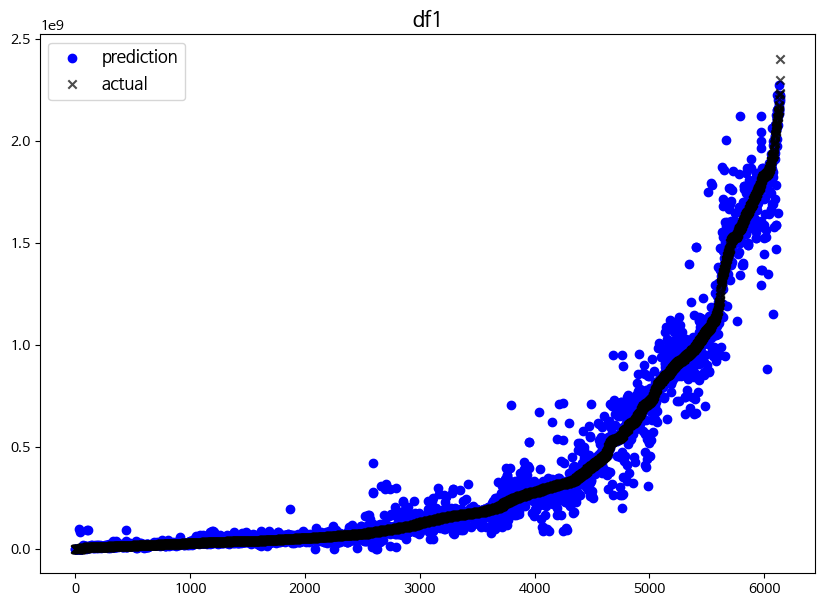

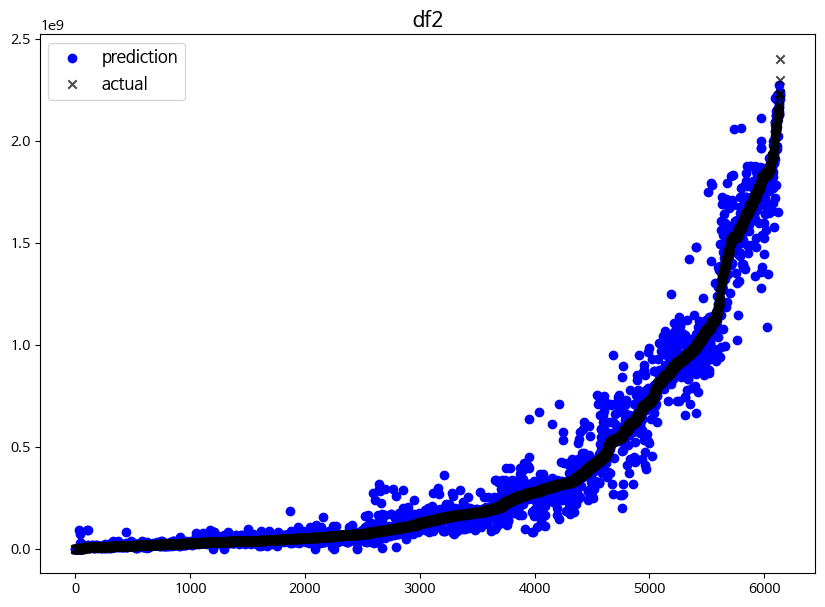

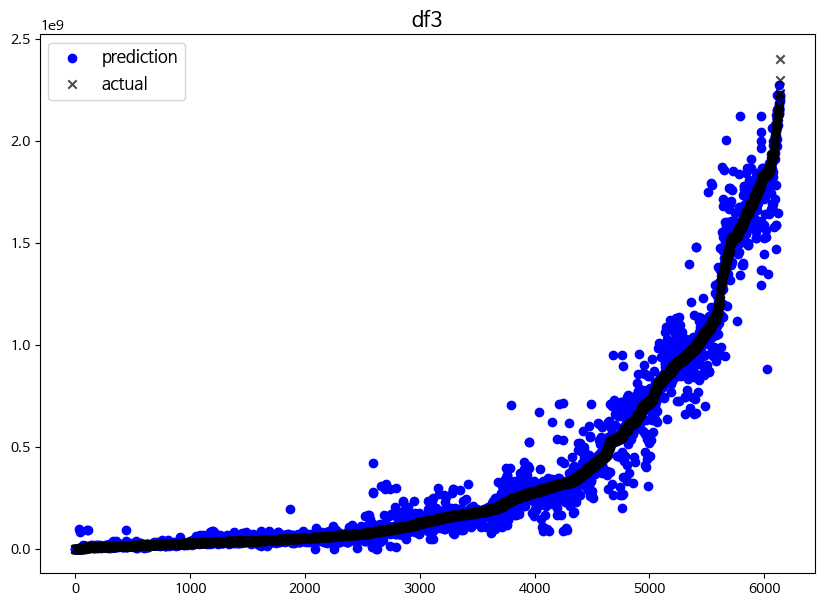

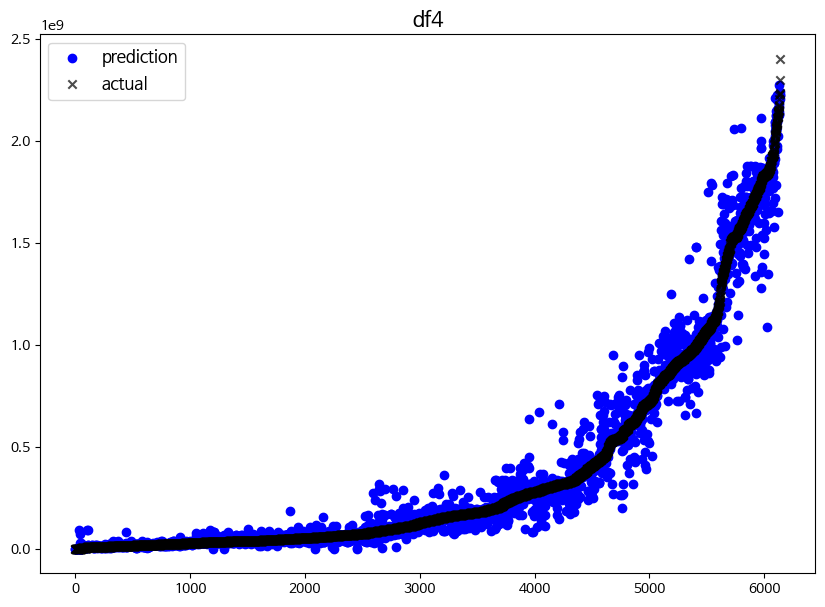

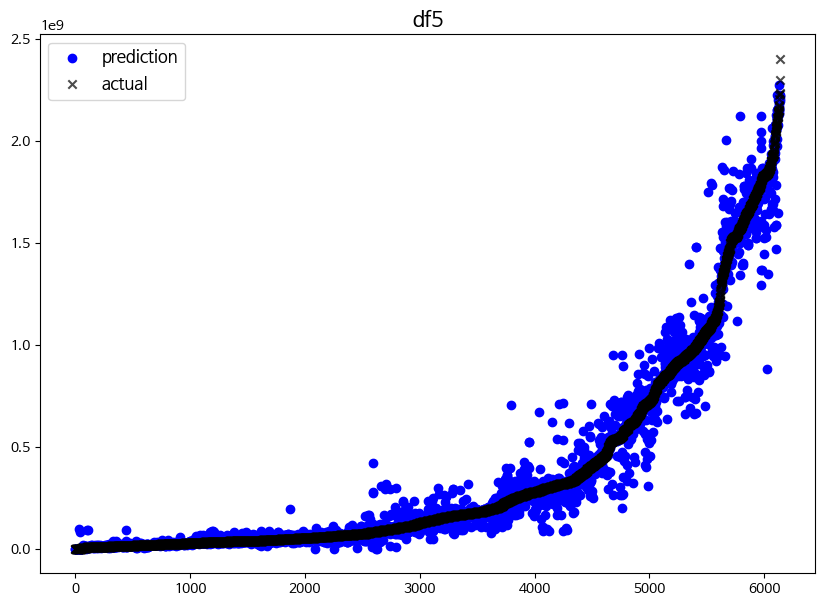

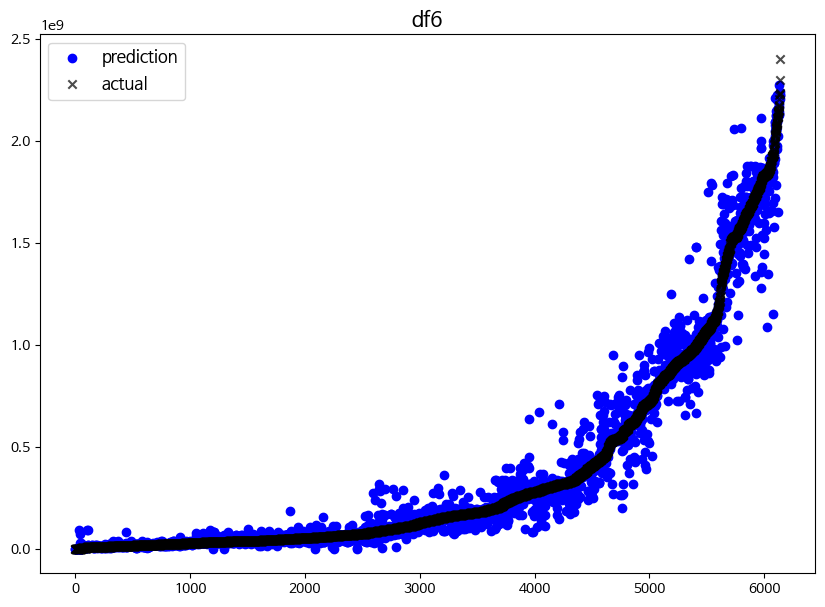

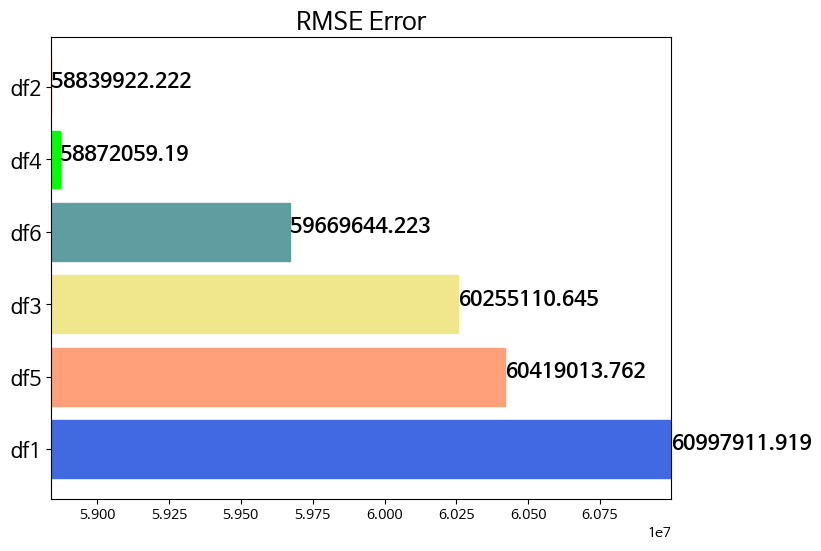



RMSE and Adjusted R-Squared
             rmse  Adjusted R_2
df2  5.883992e+07      0.985983
df4  5.887206e+07      0.985967
df6  5.966964e+07      0.985585
df3  6.025511e+07      0.985300
df5  6.041901e+07      0.985220
df1  6.099791e+07      0.984936


In [13]:
from sklearn.tree import DecisionTreeRegressor

# 기본 모델 생성
dt_base = DecisionTreeRegressor(random_state=42)

# 각 데이터에 대해 모델 학습과 평가 수행
my_predictions = {}  # 결과를 저장할 딕셔너리
for i, (df_train, df_test) in enumerate(zip(dfs_train, dfs_test), start=1):
  # feature, target 분리
  X_train = df_train.drop(['reserve_qy'], axis=1)
  y_train = df_train['reserve_qy']

  X_test = df_test.drop(['reserve_qy'], axis=1)
  y_test = df_test['reserve_qy']

  # 모델 학습
  dt_base.fit(X_train, y_train)

  # 모델 예측
  dt_pred = dt_base.predict(X_test)
  dt_pred = np.expm1(dt_pred) # 원래 스케일로

  # 모델 평가 및 시각화
  model_eval(f'df{i}', dt_pred, y_test)

- 성능은 대부분 이상치 처리를 한 모델들이 이상치 처리를 하지 않은 모델들에 비해 좋다.
- 데이터 스케일링 방식에 따른 차이는 두드러지지 않는 것 같다.

### **b) 하이퍼 파라미터 튜닝**

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# 하이퍼 파라미터 그리드 설정
param_grid = {
    'max_depth': [None, 10, 20, 30],            # 최대 깊이 후보값들
    'min_samples_split': [2, 5, 10],            # 노드 분할을 위한 최소 샘플 수 후보값들
    'min_samples_leaf': [1, 2, 4],              # 리프 노드를 위한 최소 샘플 수 후보값들
    'max_features': ['auto', 'sqrt', 'log2']    # 최대 특성 개수 후보값들
}

# 평가 지표 설정
scoring = {
    'MSE': make_scorer(mean_squared_error),
    'Adj_R2': make_scorer(lambda y_true, y_pred: 1 - (1 - r2_score(y_true, y_pred)) * (len(y_true) - 1) / (len(y_true) - X_test.shape[1] - 1))
}

In [17]:
# 하이퍼 파라미터 튜닝 및 모델 학습
dt_best_models = []

for i, (df_train, df_test) in enumerate(zip(dfs_train, dfs_test), start=1):
  # feature, target 분리
  X_train = df_train.drop(['reserve_qy'], axis=1)
  y_train = df_train['reserve_qy']

  X_test = df_test.drop(['reserve_qy'], axis=1)
  y_test = df_test['reserve_qy']

  # GridSearchCV를 이용하여 최적 파라미터 탐색
  dt_grid_search = GridSearchCV(dt_base, param_grid, cv = 5, scoring = scoring, refit = 'MSE')
  dt_grid_search.fit(X_train, y_train)

  # 최적 모델 저장
  dt_best_models.append(dt_grid_search.best_estimator_)

  print(f"===== Data Set {i} =====")
  print("최적 파라미터 조합:", dt_grid_search.best_params_)
  print()

===== Data Set 1 =====
최적 파라미터 조합: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}

===== Data Set 2 =====
최적 파라미터 조합: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}

===== Data Set 3 =====
최적 파라미터 조합: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5}

===== Data Set 4 =====
최적 파라미터 조합: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}

===== Data Set 5 =====
최적 파라미터 조합: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}

===== Data Set 6 =====
최적 파라미터 조합: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}



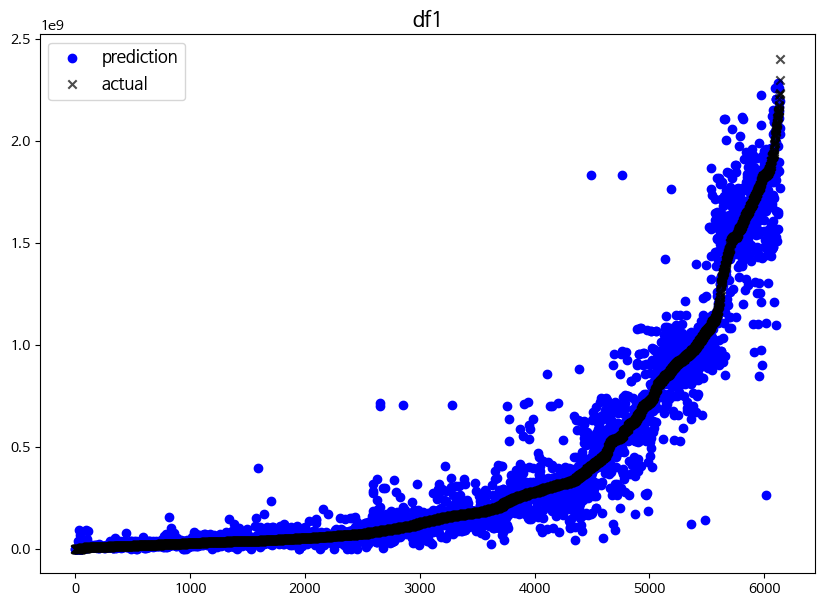

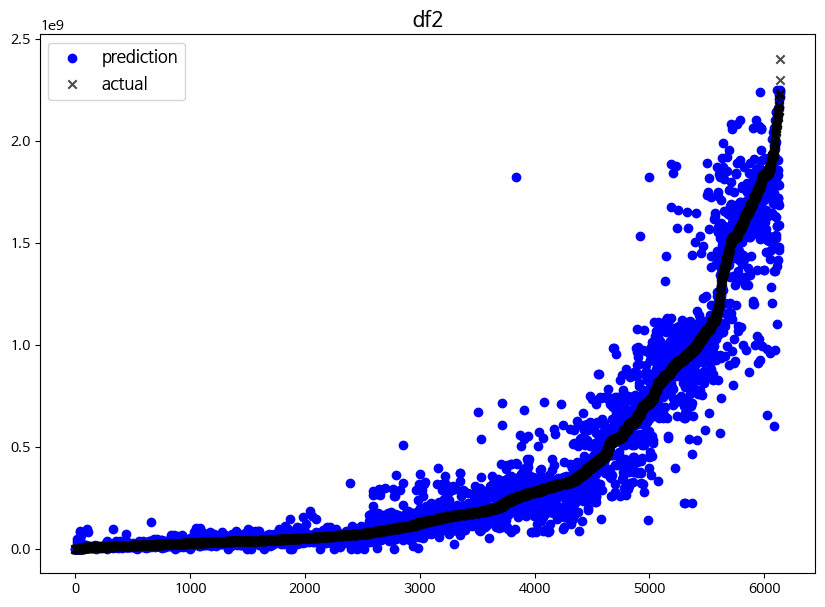

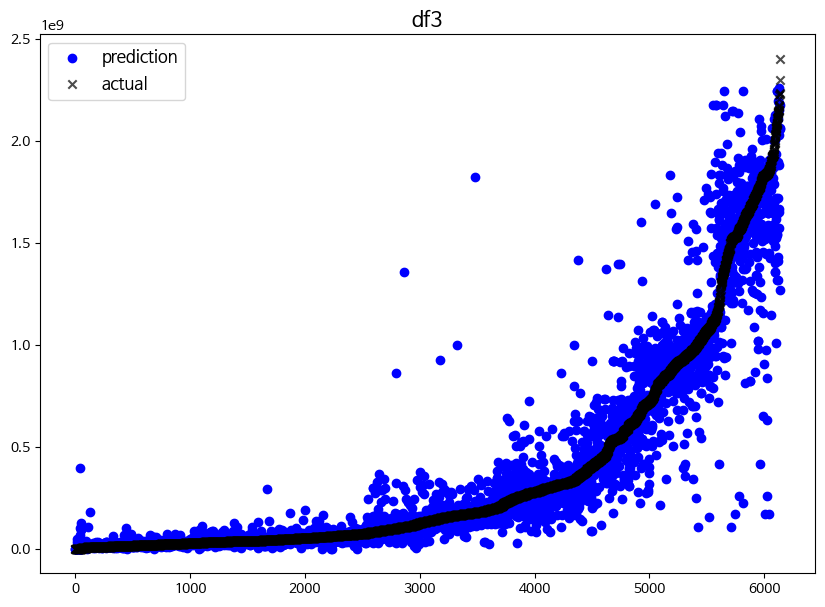

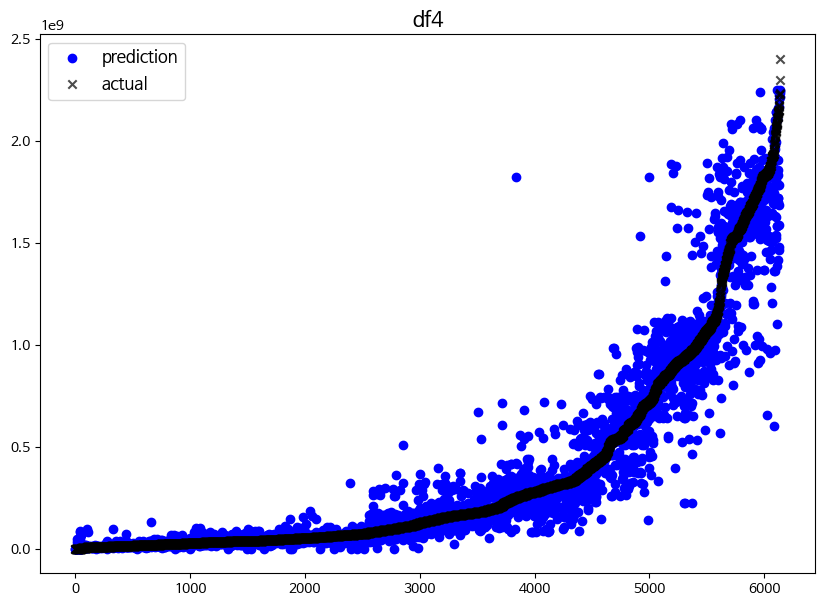

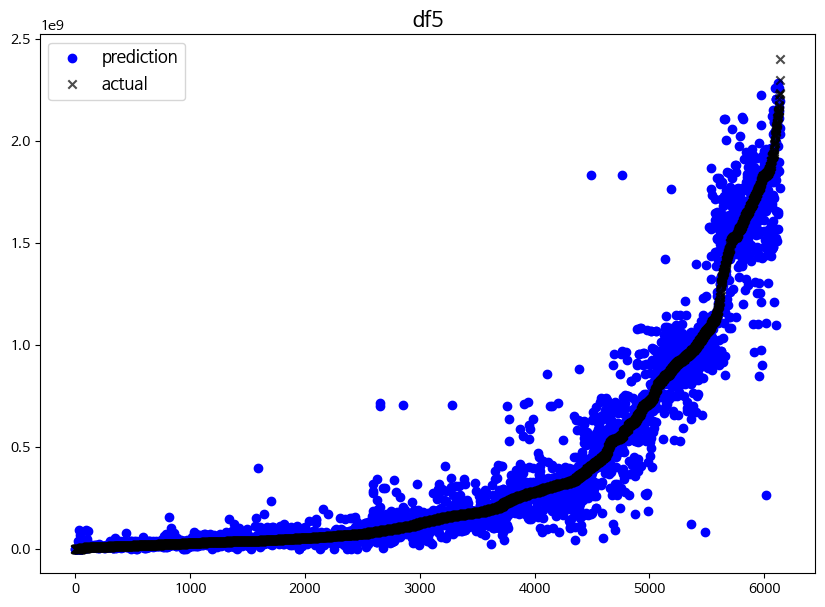

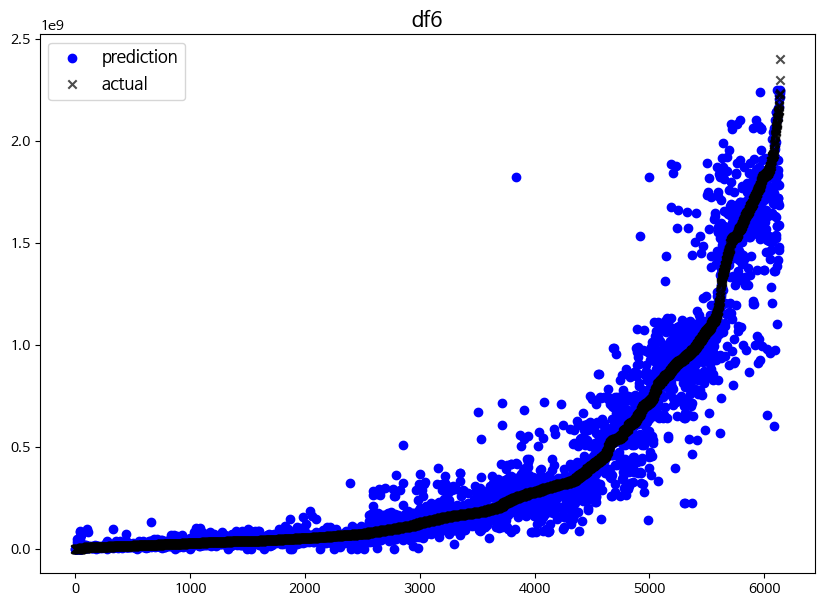

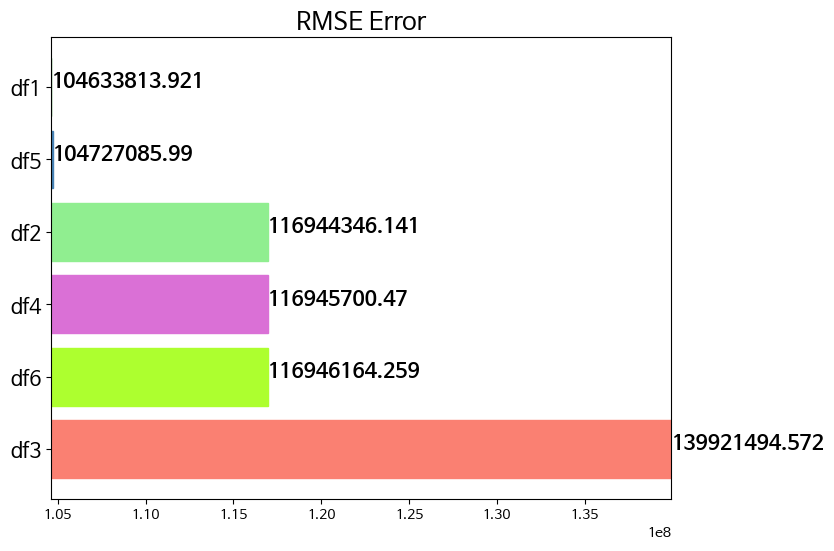



RMSE and Adjusted R-Squared
             rmse  Adjusted R_2
df1  1.046338e+08      0.955674
df5  1.047271e+08      0.955595
df2  1.169443e+08      0.944630
df4  1.169457e+08      0.944628
df6  1.169462e+08      0.944628
df3  1.399215e+08      0.920734


In [18]:
### 모델 성능 비교
# 각 데이터에 대해 최적 파라미터로 튜닝된 모델로 학습 및 평가

my_predictions = {}  # 결과를 저장할 딕셔너리
for i, (df_train, df_test) in enumerate(zip(dfs_train, dfs_test), start = 1):
  # feature, target 분리
  X_train = df_train.drop(['reserve_qy'], axis = 1)
  y_train = df_train['reserve_qy']

  X_test = df_test.drop(['reserve_qy'], axis = 1)
  y_test = df_test['reserve_qy']

  # 최적 파라미터로 튜닝된 모델 사용
  dt_tuned = dt_best_models[i - 1]  # 인덱스가 0부터 시작하므로 (i-1)로 접근

  # 모델 학습
  dt_tuned.fit(X_train, y_train)

  # 모델 예측
  dt_pred = dt_tuned.predict(X_test)
  dt_pred = np.expm1(dt_pred) # 원래 스케일로

  # 모델 평가 및 시각화
  model_eval(f'df{i}', dt_pred, y_test)

- df3에 대해 튜닝된 모델의 성능이 가장 좋음을 확인할 수 있다.
  - 이상치 제거 x,

## **4-2. 랜덤 포레스트(Random Forest)**

### **a) Base Model**

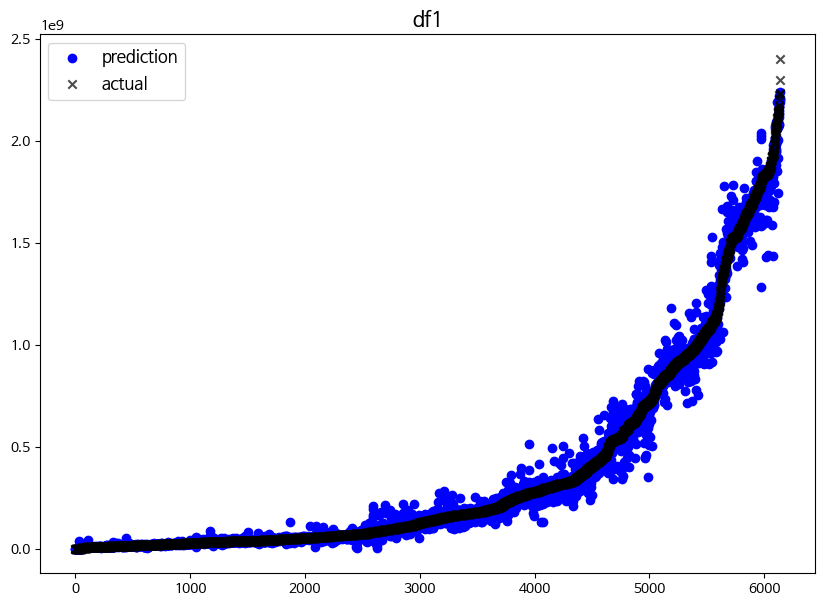

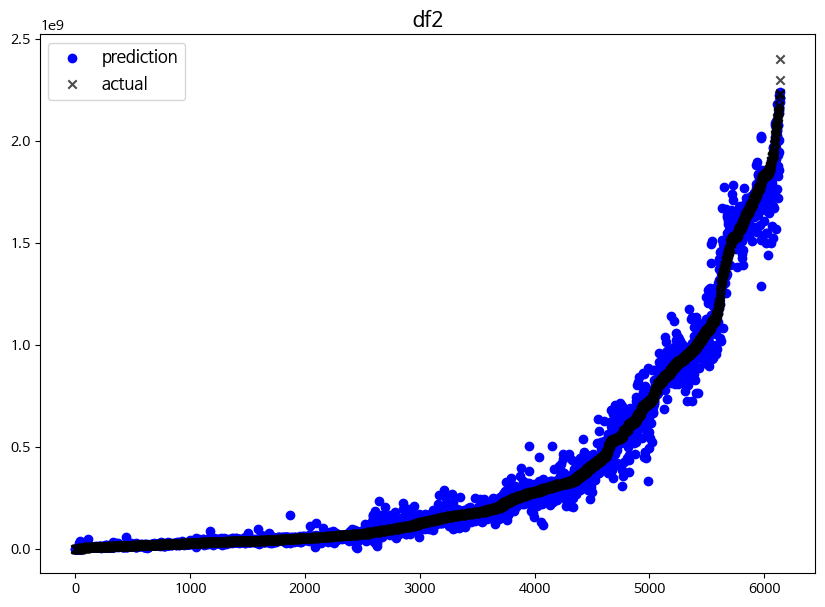

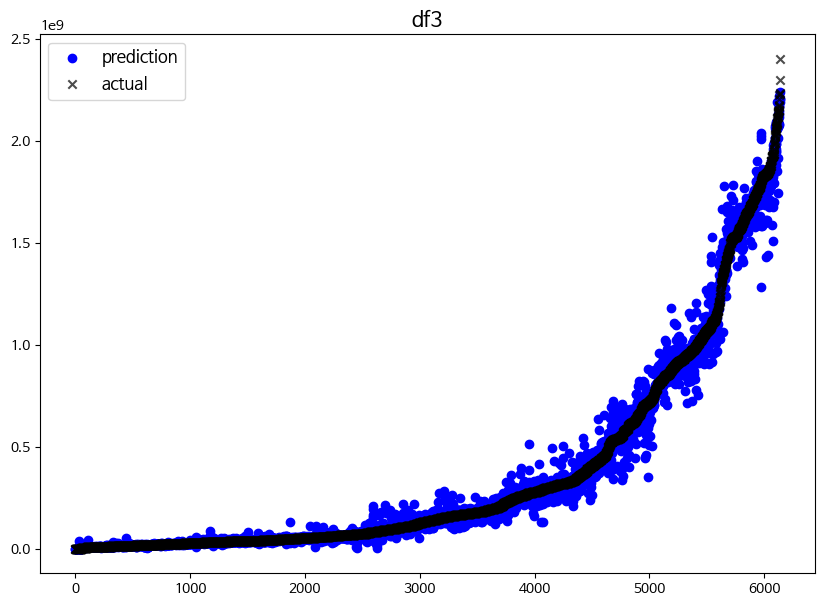

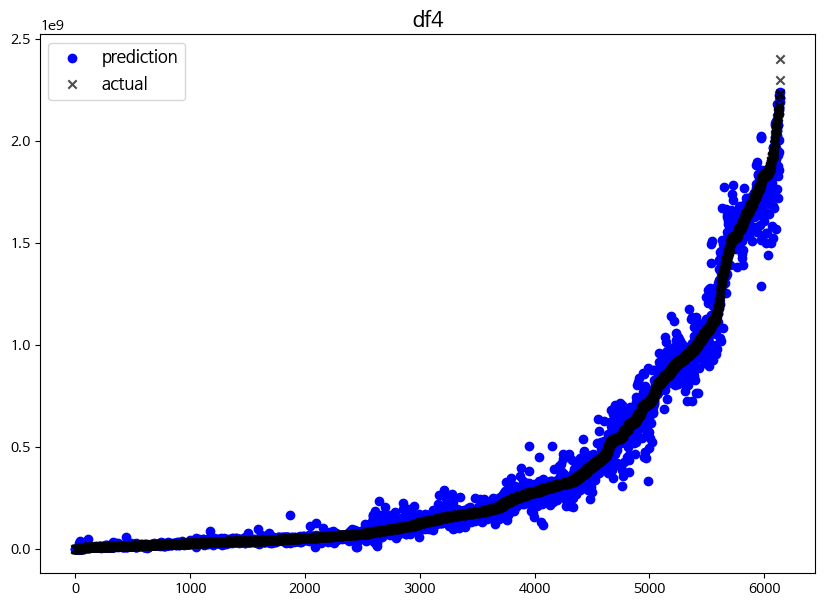

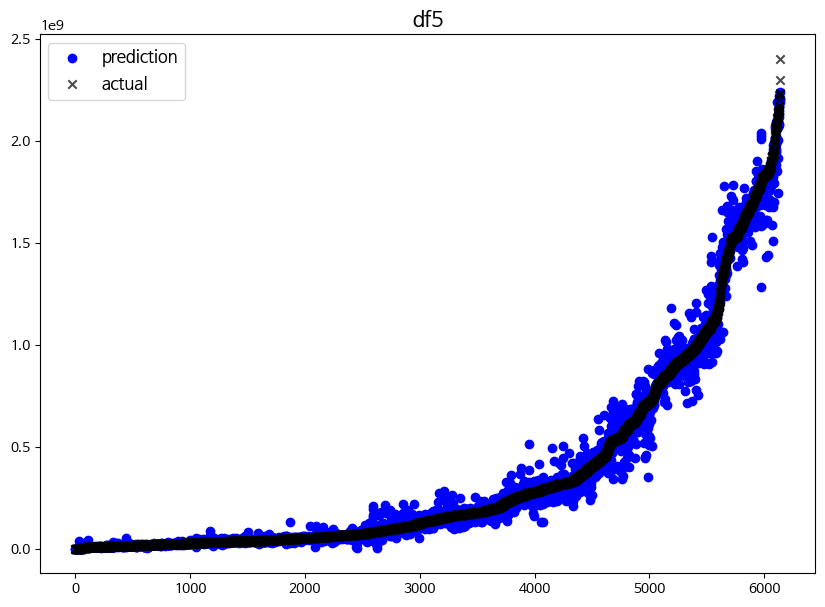

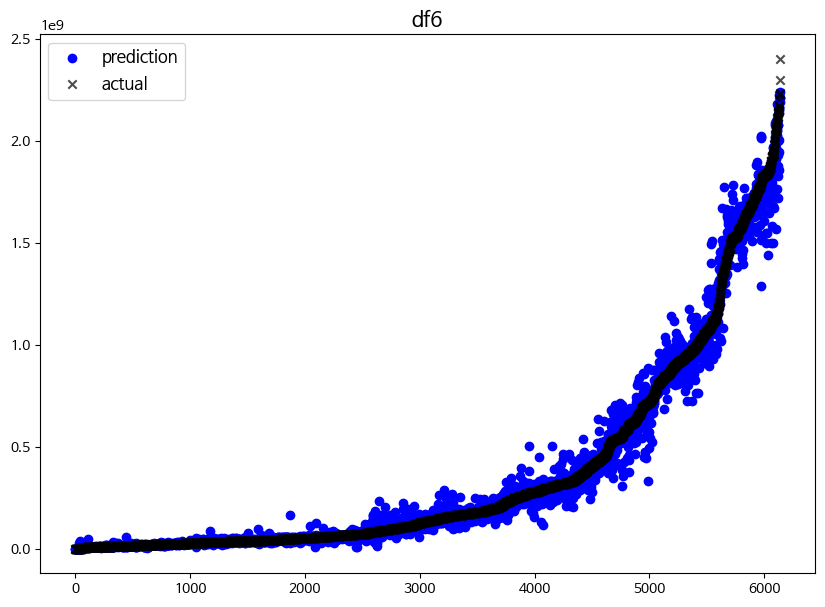

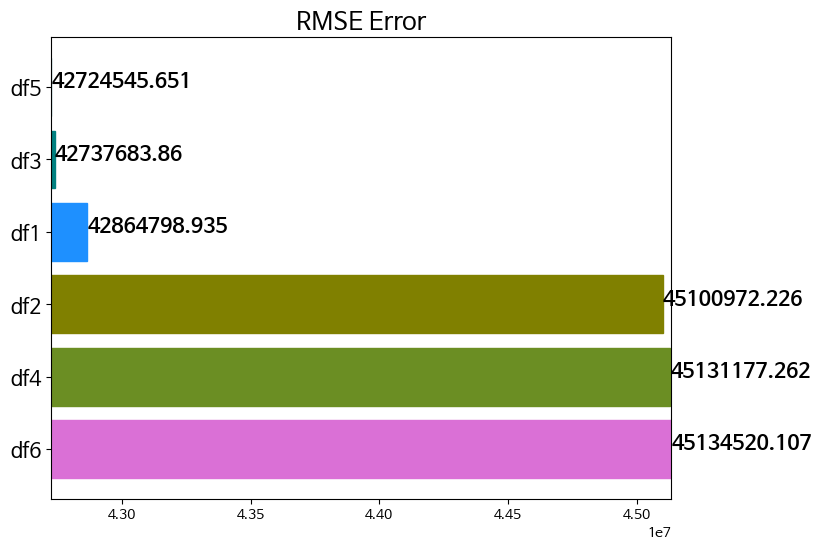



RMSE and Adjusted R-Squared
             rmse  Adjusted R_2
df5  4.272455e+07      0.992610
df3  4.273768e+07      0.992605
df1  4.286480e+07      0.992561
df2  4.510097e+07      0.991765
df4  4.513118e+07      0.991753
df6  4.513452e+07      0.991752


In [20]:
from sklearn.ensemble import RandomForestRegressor

# 기본 모델 생성
rf_base = RandomForestRegressor(n_jobs = -1, random_state = 42)

# 각 데이터에 대해 모델 학습과 평가 수행
my_predictions = {}  # 결과를 저장할 딕셔너리
for i, (df_train, df_test) in enumerate(zip(dfs_train, dfs_test), start=1):
  # feature, target 분리
  X_train = df_train.drop(['reserve_qy'], axis = 1)
  y_train = df_train['reserve_qy']

  X_test = df_test.drop(['reserve_qy'], axis = 1)
  y_test = df_test['reserve_qy']

  # 모델 학습
  rf_base.fit(X_train, y_train)

  # 모델 예측
  rf_pred = rf_base.predict(X_test)
  rf_pred = np.expm1(rf_pred)

  # 모델 평가 및 시각화
  model_eval(f'df{i}', rf_pred, y_test)

### **b) 하이퍼 파라미터 튜닝**

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# 하이퍼 파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200],  # 트리 개수
    'max_depth': [10, 20],     # 최대 깊이(None은 제한 없음을 의미)
    'min_samples_split': [2, 5, 10], # 노드 분할을 위한 최소 샘플 수
    'min_samples_leaf': [1, 2, 4],   # 리프 노드를 위한 최소 샘플 수
}

# 평가 지표 설정
scoring = {
    'MSE': make_scorer(mean_squared_error),
    'Adj_R2': make_scorer(lambda y_true, y_pred: 1 - (1 - r2_score(y_true, y_pred)) * (len(y_true) - 1) / (len(y_true) - X_test.shape[1] - 1))
}

In [24]:
# 하이퍼 파라미터 튜닝 및 모델 학습
rf_best_models = []

for i, (df_train, df_test) in enumerate(zip(dfs_train, dfs_test), start=1):
  # feature, target 분리
  X_train = df_train.drop(['reserve_qy'], axis=1)
  y_train = df_train['reserve_qy']

  X_test = df_test.drop(['reserve_qy'], axis=1)
  y_test = df_test['reserve_qy']

  # GridSearchCV를 이용하여 최적 파라미터 탐색
  rf_grid_search = GridSearchCV(rf_base, param_grid, cv = 5, scoring = scoring, refit = 'MSE')
  rf_grid_search.fit(X_train, y_train)

  # 최적 모델 저장
  rf_best_models.append(rf_grid_search.best_estimator_)

  print(f"===== Data Set {i} =====")
  print("최적 파라미터 조합:", rf_grid_search.best_params_)
  print()

===== Data Set 1 =====
최적 파라미터 조합: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}

===== Data Set 2 =====
최적 파라미터 조합: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}

===== Data Set 3 =====
최적 파라미터 조합: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}

===== Data Set 4 =====
최적 파라미터 조합: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}

===== Data Set 5 =====
최적 파라미터 조합: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}

===== Data Set 6 =====
최적 파라미터 조합: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}



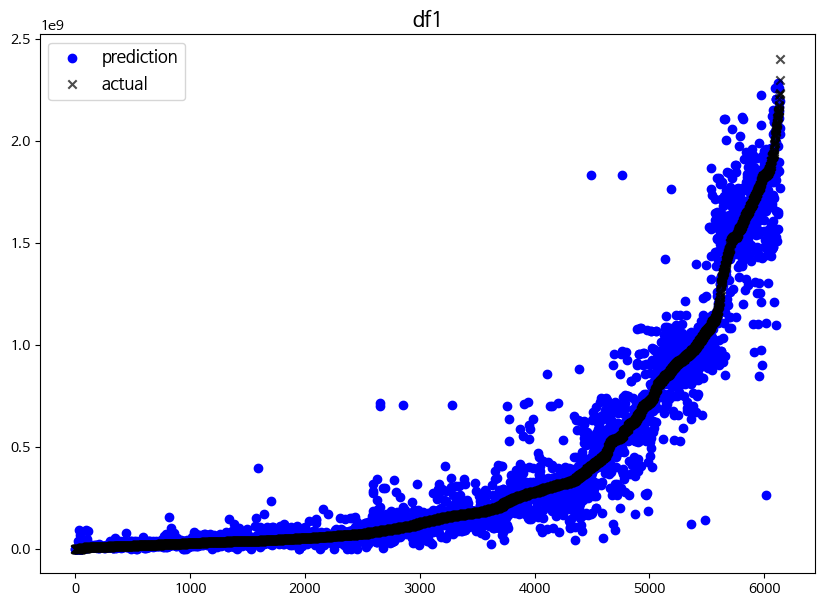

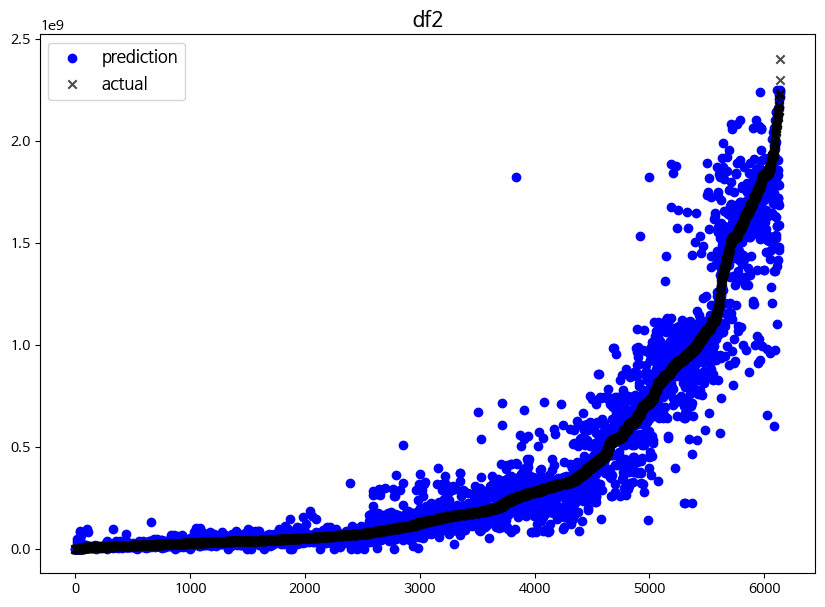

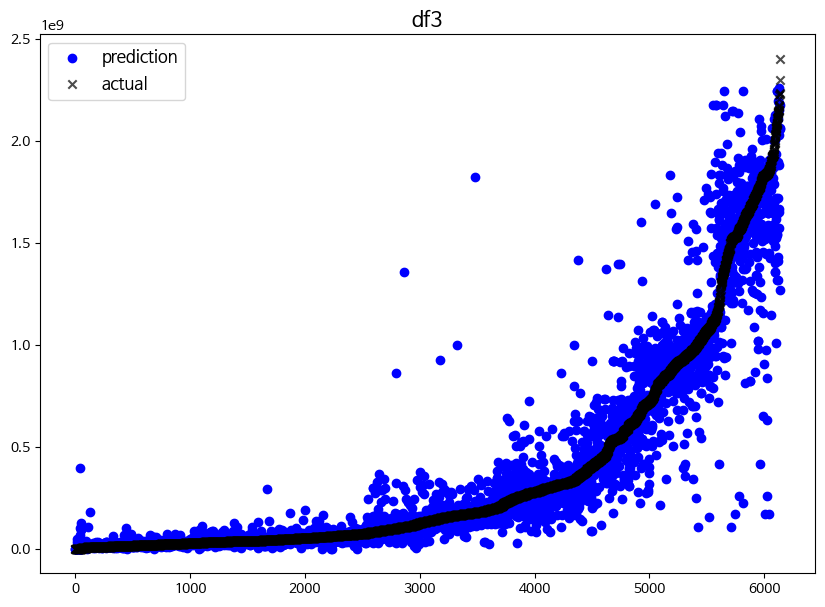

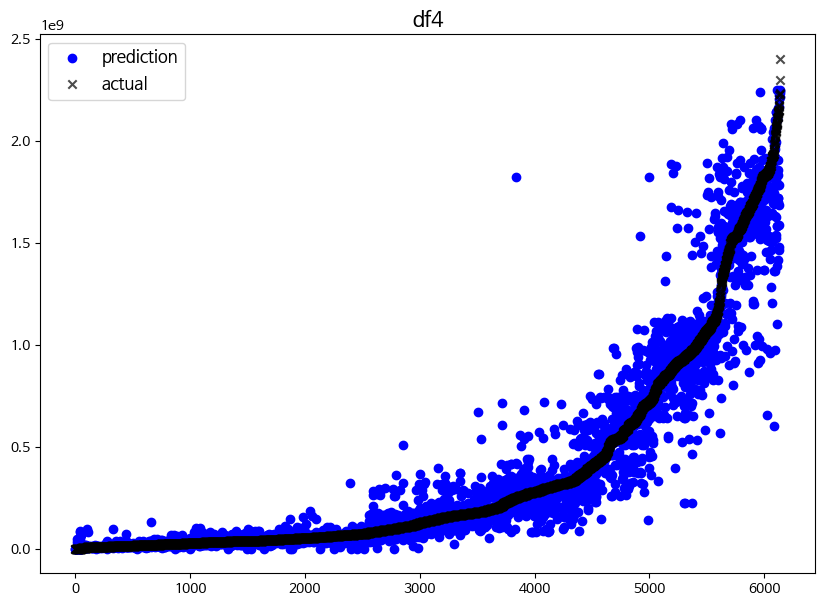

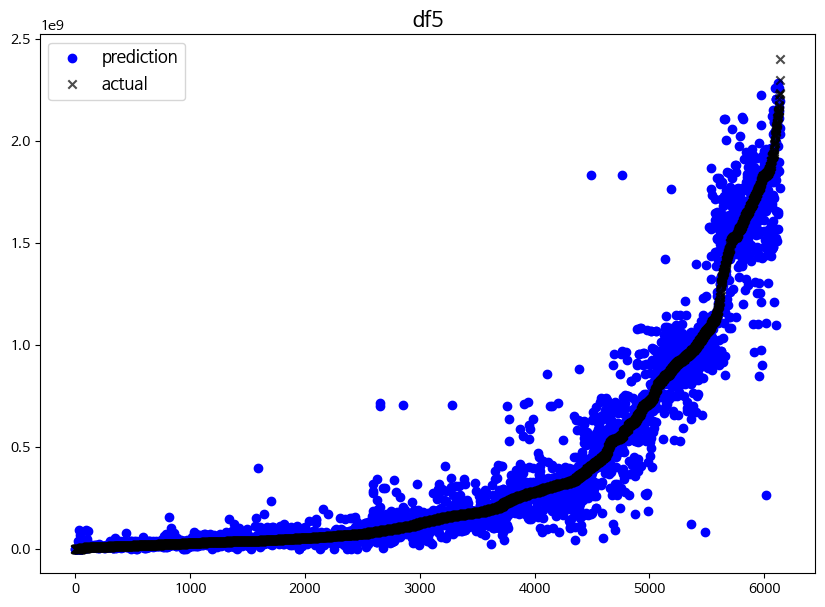

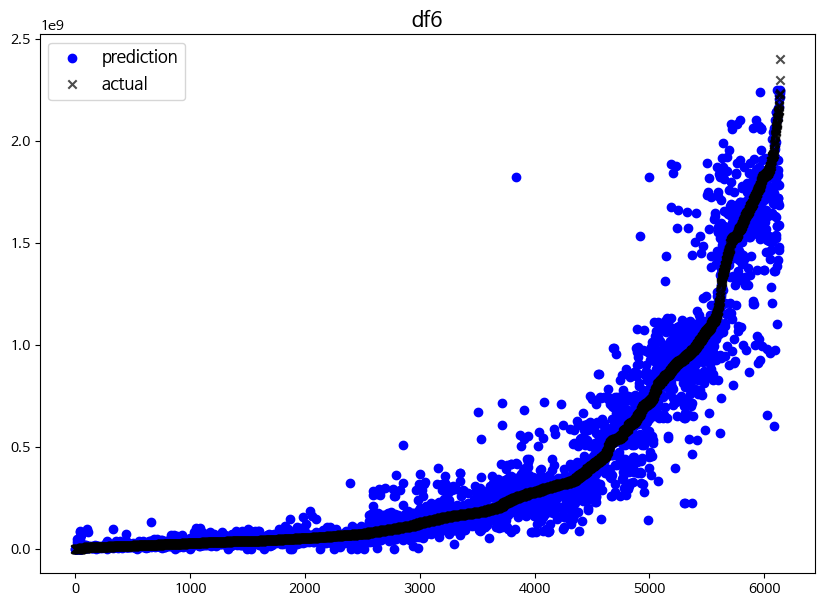

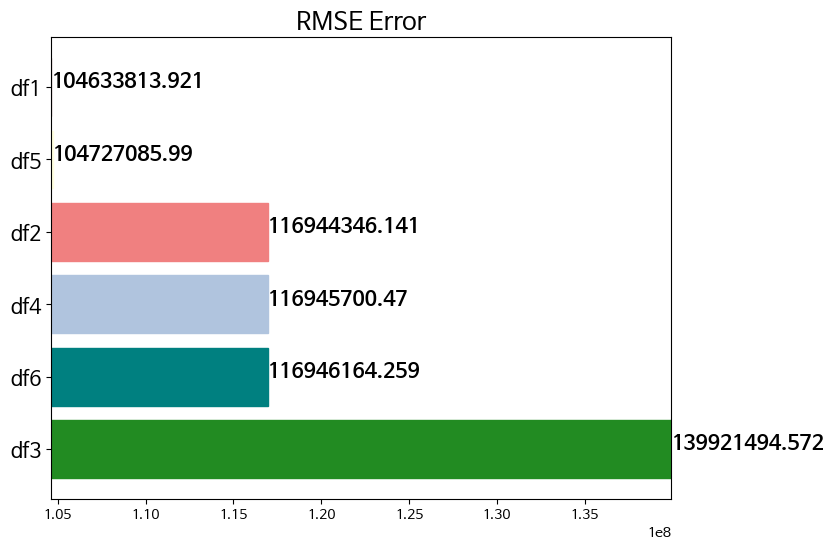



RMSE and Adjusted R-Squared
             rmse  Adjusted R_2
df1  1.046338e+08      0.955674
df5  1.047271e+08      0.955595
df2  1.169443e+08      0.944630
df4  1.169457e+08      0.944628
df6  1.169462e+08      0.944628
df3  1.399215e+08      0.920734


In [25]:
### 모델 성능 비교
# 각 데이터에 대해 최적 파라미터로 튜닝된 모델로 학습 및 평가

my_predictions = {}  # 결과를 저장할 딕셔너리
for i, (df_train, df_test) in enumerate(zip(dfs_train, dfs_test), start = 1):
  # feature, target 분리
  X_train = df_train.drop(['reserve_qy'], axis = 1)
  y_train = df_train['reserve_qy']

  X_test = df_test.drop(['reserve_qy'], axis = 1)
  y_test = df_test['reserve_qy']

  # 최적 파라미터로 튜닝된 모델 사용
  rf_tuned = dt_best_models[i - 1]  # 인덱스가 0부터 시작하므로 (i-1)로 접근

  # 모델 학습
  rf_tuned.fit(X_train, y_train)

  # 모델 예측
  rf_pred = rf_tuned.predict(X_test)
  rf_pred = np.expm1(rf_pred) # 원래 스케일로

  # 모델 평가 및 시각화
  model_eval(f'df{i}', rf_pred, y_test)

## **4-3. GBM**

### **a) Base Model**

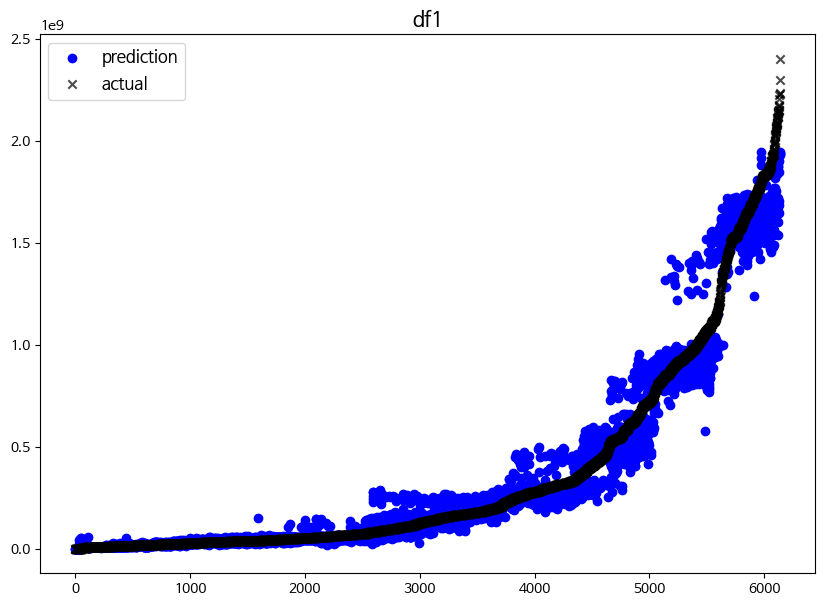

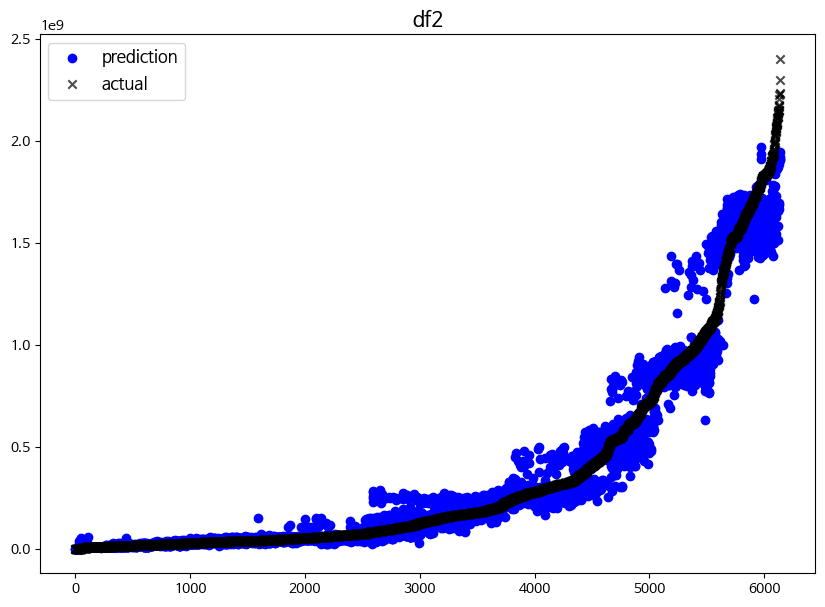

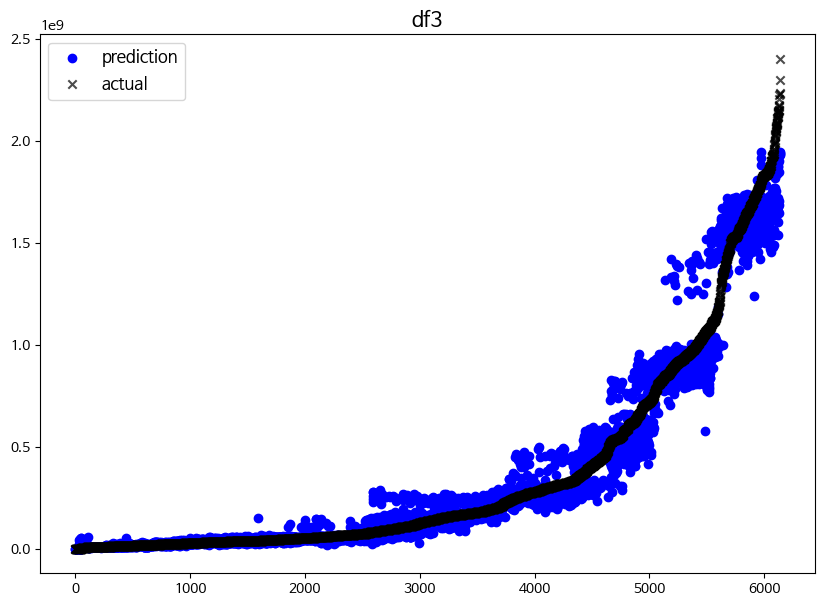

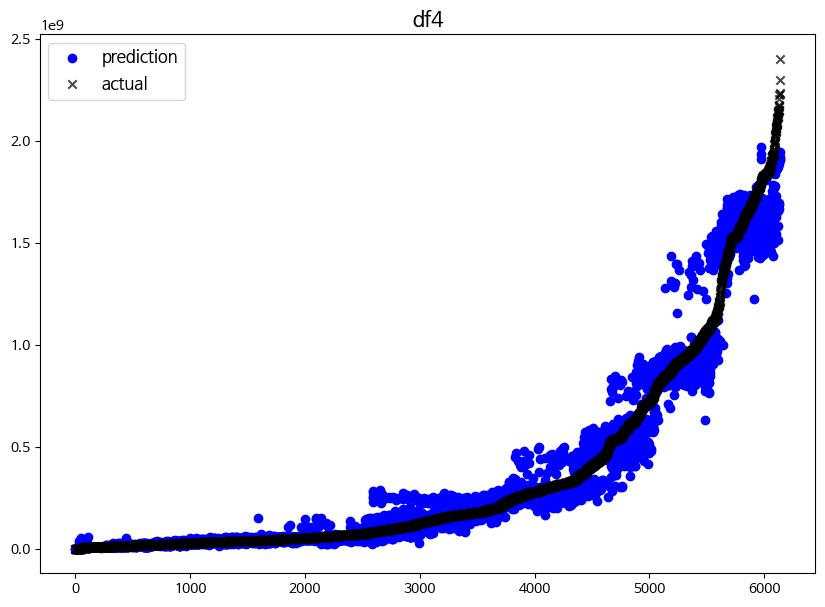

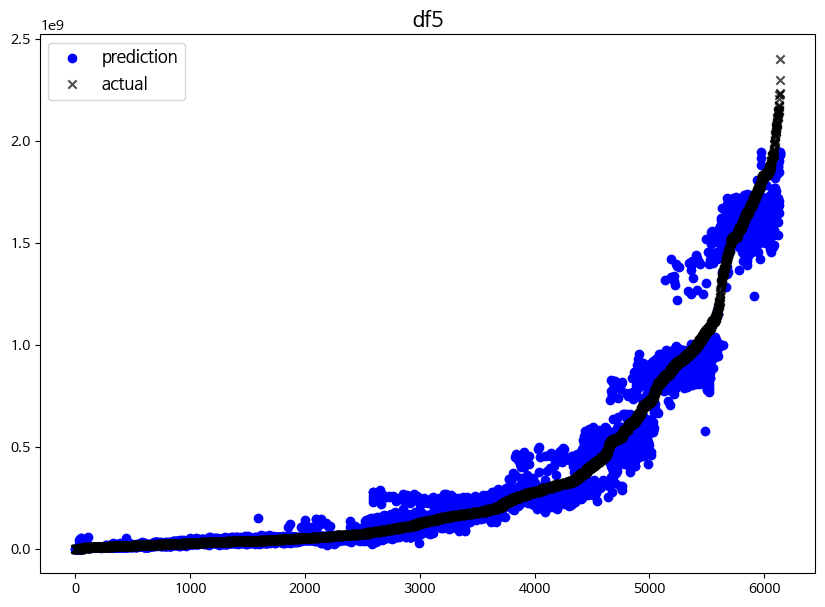

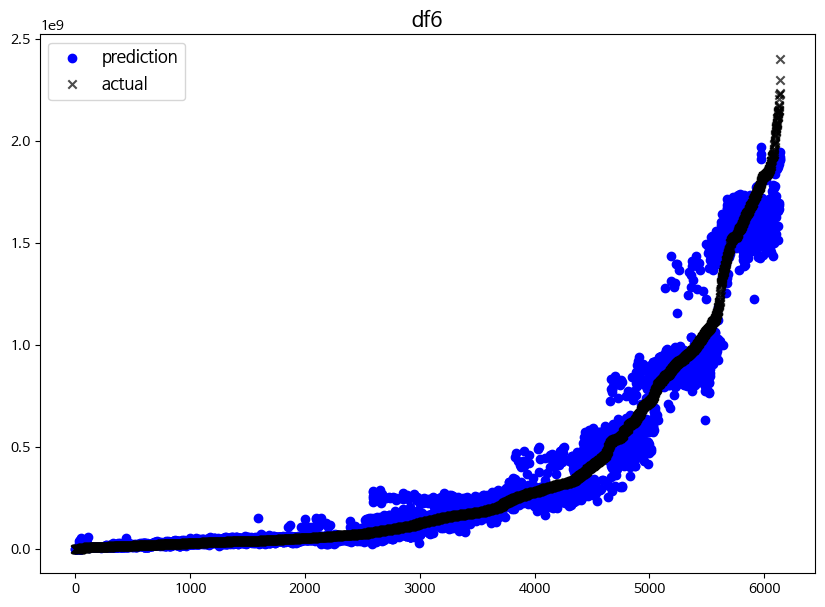

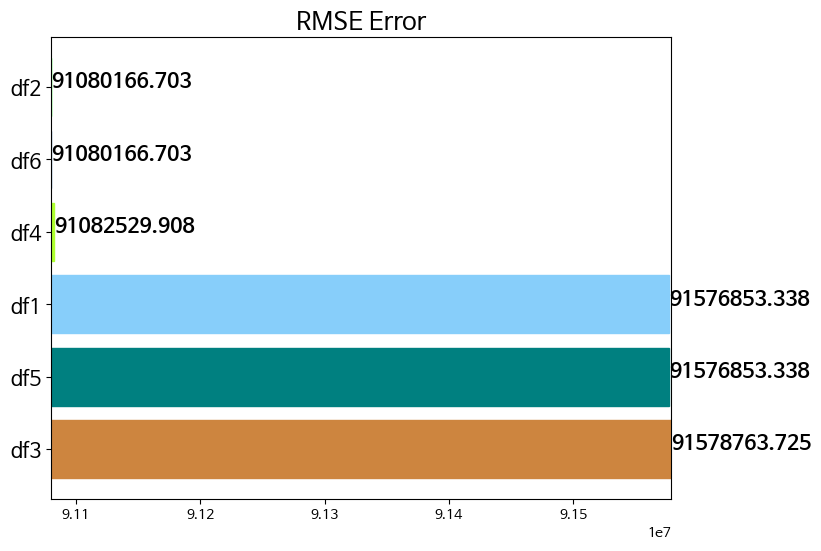



RMSE and Adjusted R-Squared
             rmse  Adjusted R_2
df2  9.108017e+07      0.966413
df6  9.108017e+07      0.966413
df4  9.108253e+07      0.966412
df1  9.157685e+07      0.966046
df5  9.157685e+07      0.966046
df3  9.157876e+07      0.966045


In [13]:
from sklearn.ensemble import GradientBoostingRegressor

# 기본 모델 생성
gbm_base = GradientBoostingRegressor(random_state=42)

# 각 데이터에 대해 모델 학습과 평가 수행
my_predictions = {}  # 결과를 저장할 딕셔너리
for i, (df_train, df_test) in enumerate(zip(dfs_train, dfs_test), start=1):
  # feature, target 분리
  X_train = df_train.drop(['reserve_qy'], axis=1)
  y_train = df_train['reserve_qy']

  X_test = df_test.drop(['reserve_qy'], axis=1)
  y_test = df_test['reserve_qy']

  # 모델 학습
  gbm_base.fit(X_train, y_train)

  # 모델 예측
  gbm_pred = gbm_base.predict(X_test)
  gbm_pred = np.expm1(gbm_pred)

  # 모델 평가 및 시각화
  model_eval(f'df{i}', gbm_pred, y_test)

### **b) 하이퍼 파라미터 튜닝**

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# 하이퍼 파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200],  # 트리 개수
    'learning_rate': [0.05, 0.1, 0.2],  # 학습률
    'max_depth': [3, 5, 7],     # 최대 깊이
}

# 평가 지표 설정
scoring = {
    'MSE': make_scorer(mean_squared_error),
    'Adj_R2': make_scorer(lambda y_true, y_pred: 1 - (1 - r2_score(y_true, y_pred)) * (len(y_true) - 1) / (len(y_true) - X_test.shape[1] - 1))
}

In [16]:
### 하이퍼 파라미터 튜닝 및 모델 학습
gbm_best_models = []

for i, (df_train, df_test) in enumerate(zip(dfs_train, dfs_test), start=1):
  # feature, target 분리
  X_train = df_train.drop(['reserve_qy'], axis=1)
  y_train = df_train['reserve_qy']

  X_test = df_test.drop(['reserve_qy'], axis=1)
  y_test = df_test['reserve_qy']

  # GridSearchCV를 이용하여 최적 파라미터 탐색
  gbm_grid_search = GridSearchCV(gbm_base, param_grid, cv=5, scoring=scoring, refit='MSE')
  gbm_grid_search.fit(X_train, y_train)

  # 최적 모델 저장
  gbm_best_models.append(gbm_grid_search.best_estimator_)

  print(f"===== Data Set {i} =====")
  print("최적 파라미터 조합:", gbm_grid_search.best_params_)
  print()

===== Data Set 1 =====
최적 파라미터 조합: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}

===== Data Set 2 =====
최적 파라미터 조합: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}

===== Data Set 3 =====
최적 파라미터 조합: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}

===== Data Set 4 =====
최적 파라미터 조합: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}

===== Data Set 5 =====
최적 파라미터 조합: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}

===== Data Set 6 =====
최적 파라미터 조합: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}



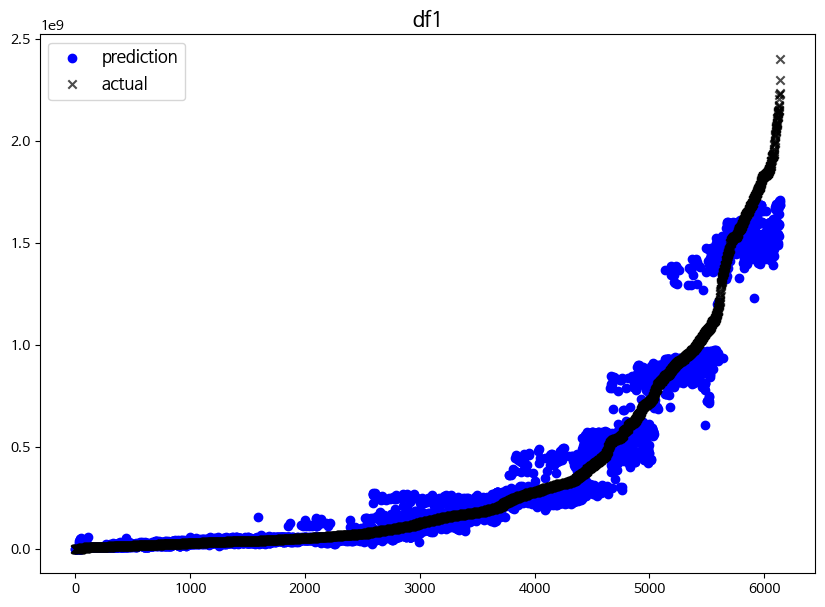

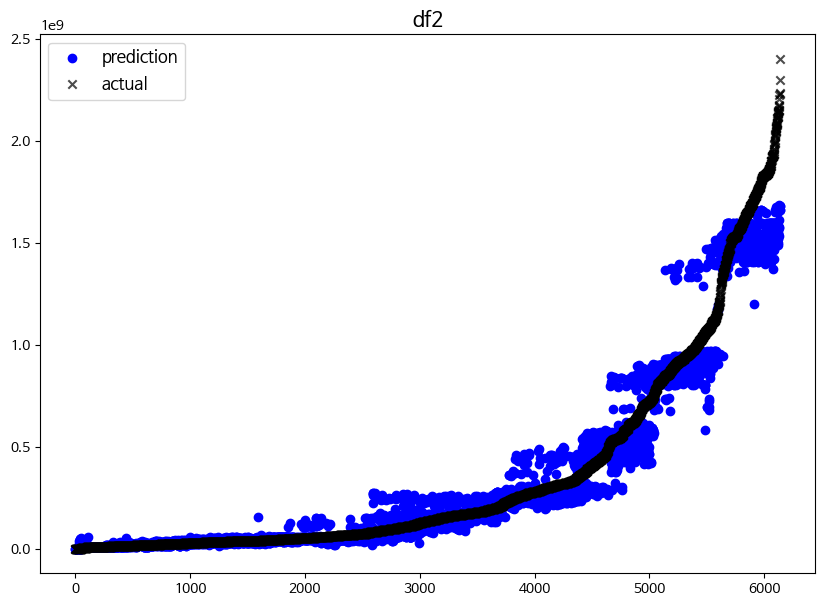

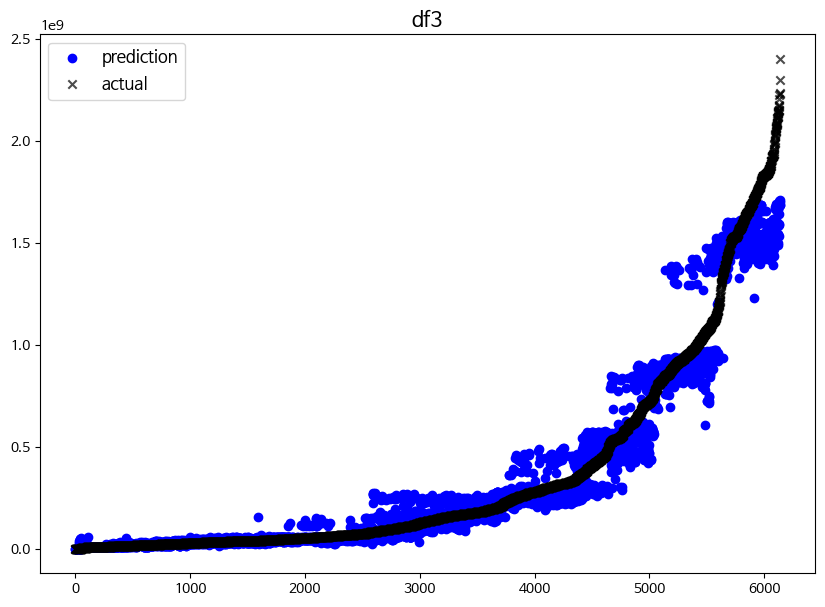

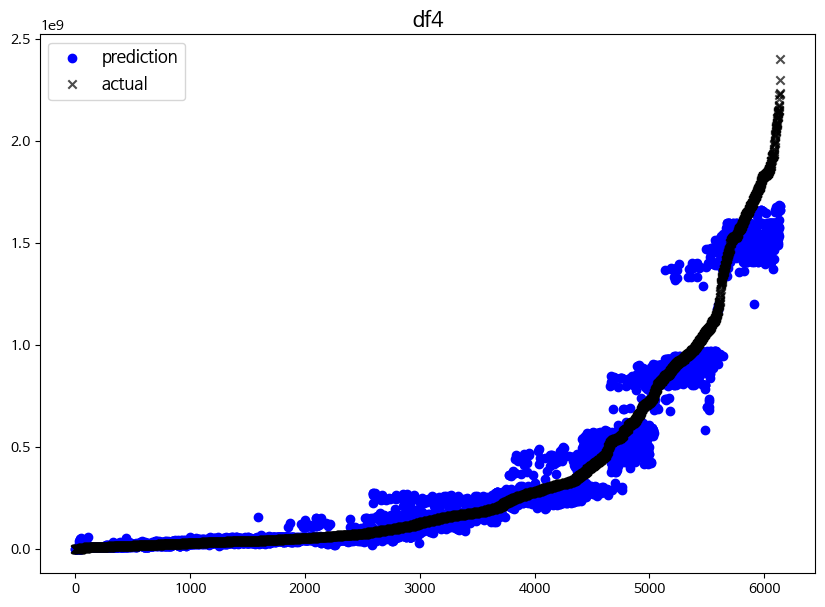

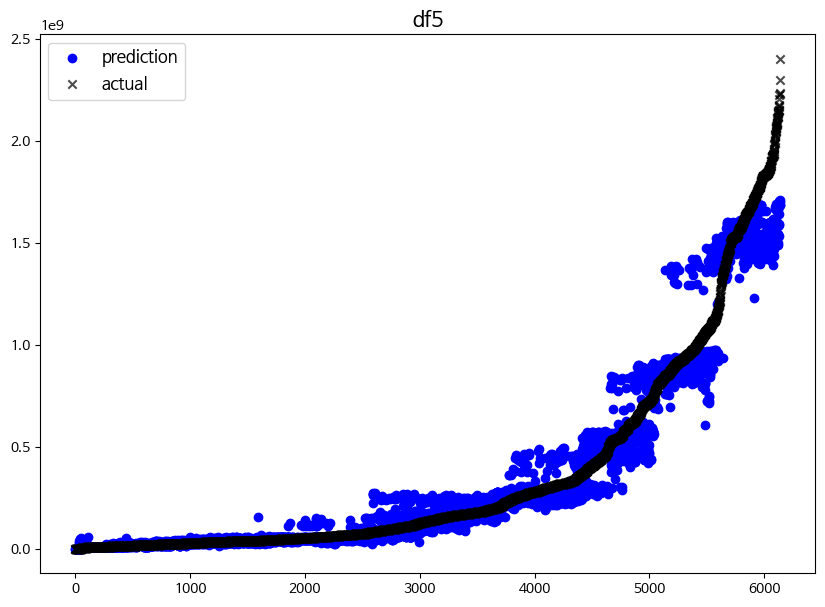

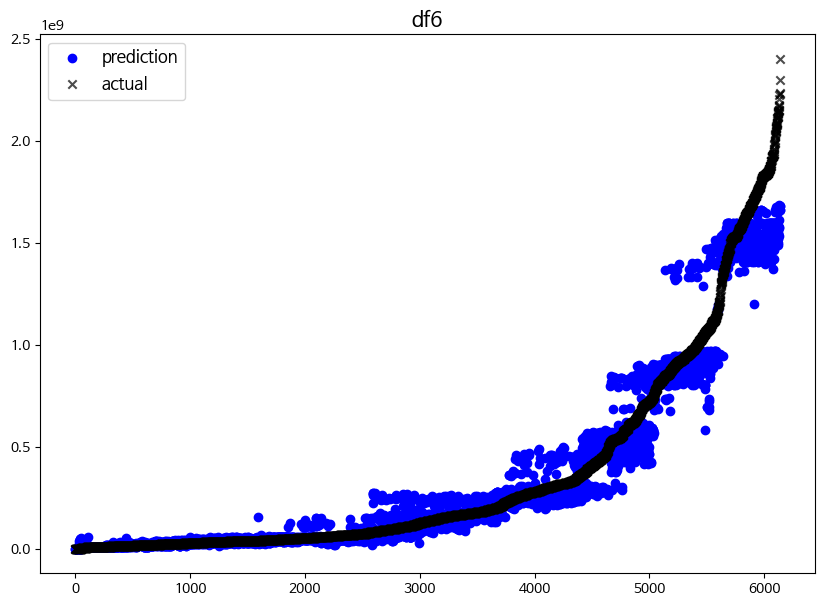

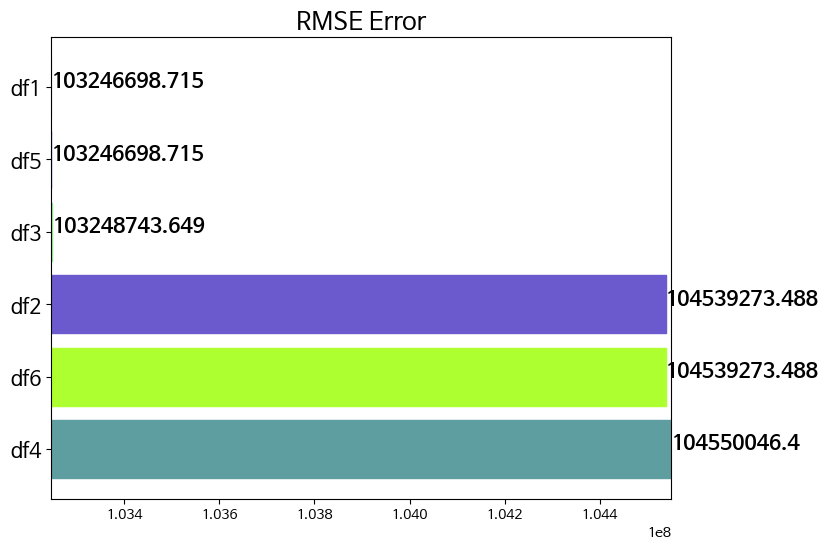



RMSE and Adjusted R-Squared
             rmse  Adjusted R_2
df1  1.032467e+08      0.956841
df5  1.032467e+08      0.956841
df3  1.032487e+08      0.956839
df2  1.045393e+08      0.955754
df6  1.045393e+08      0.955754
df4  1.045500e+08      0.955745


In [17]:
### 모델 성능 비교
# 각 데이터에 대해 최적 파라미터로 튜닝된 모델로 학습 및 평가

my_predictions = {}  # 결과를 저장할 딕셔너리
for i, (df_train, df_test) in enumerate(zip(dfs_train, dfs_test), start=1):
  # feature, target 분리
  X_train = df_train.drop(['reserve_qy'], axis=1)
  y_train = df_train['reserve_qy']

  X_test = df_test.drop(['reserve_qy'], axis=1)
  y_test = df_test['reserve_qy']

  # 최적 파라미터로 튜닝된 모델 사용
  gbm_tuned = gbm_best_models[i - 1]  # 인덱스가 0부터 시작하므로 (i-1)로 접근

  # 모델 학습
  gbm_tuned.fit(X_train, y_train)

  # 모델 예측
  gbm_pred = gbm_tuned.predict(X_test)
  gbm_pred = np.expm1(gbm_pred)  # 원래 스케일로

  # 모델 평가 및 시각화
  model_eval(f'df{i}', gbm_pred, y_test)